# Setup

In [1]:
import glob
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from random import randint
import cv2

In [2]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

In [3]:
def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

# Calculate GT/TP and Draw Graphs

In [4]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct")
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):      
        return 0.0
    if(y_bottomright_gt < y_topleft_p):        
        return 0.0
    if(x_topleft_gt > x_bottomright_p):      
        return 0.0
    if(y_topleft_gt > y_bottomright_p):
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area = (x_bottomright_p - x_topleft_p + 1 ) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [5]:
def process_single_image_results(gt_boxes, pred_boxes, iou_thr):

    detected_obj_boxes = []

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
    
        gt_idx_thr=[]
        pred_idx_thr=[]
        ious=[]

        for igb, gt_box in enumerate(gt_boxes):
            for ipb, pred_box in enumerate(pred_boxes):
                iou = calc_iou(gt_box, pred_box)

                if iou >= iou_thr:
                    detected_obj_boxes.append(gt_box)
#                 break
    
    return detected_obj_boxes

## 1. Size 60 - 70

In [6]:
gt_path = glob.glob("./graphs/bdd100k_60_70_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

310


In [43]:
all_detected_gt_boxes = []

for path in gt_path:
    img_name = get_file_name(path)
    
    result_file_name = "60_70_tested_by_nonsmall_20"
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")

    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

    detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.52)
    
    for box in detected_gt_boxes:
        box = np.array(box)
        all_detected_gt_boxes.append(box)

print(len(all_detected_gt_boxes))

253


In [44]:
size_range = 11 #60-70

sizes = np.zeros(size_range)
gt_num_sizes = np.zeros(size_range)
det_num_sizes_60_70 = np.zeros(size_range)

offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in all_gt_boxes:
    index = box[2] - box[0] - offset
    gt_num_sizes[index] += 1
print(gt_num_sizes)

for box in all_detected_gt_boxes:
    index = box[2] - box[0] - offset
    det_num_sizes_60_70[index] += 1
print(det_num_sizes_60_70)

[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
[32. 29. 30. 36. 34. 21. 31. 23. 17. 28. 29.]
[29. 25. 25. 31. 28. 12. 25. 22. 13. 21. 22.]


In [23]:
# size_range = 11 #60-70

# sizes = np.zeros(size_range)
# gt_num_sizes = np.zeros(size_range)
# det_num_sizes_60_70_e = np.zeros(size_range)

# offset = 60

# for i in range(len(sizes)):
#     sizes[i] = i + offset
# print(sizes)

# for box in all_gt_boxes:
#     index = box[2] - box[0] - offset
#     gt_num_sizes[index] += 1
# print(gt_num_sizes)

# for box in all_detected_gt_boxes:
#     index = box[2] - box[0] - offset
#     det_num_sizes_60_70_e[index] += 1
# print(det_num_sizes_60_70_e)

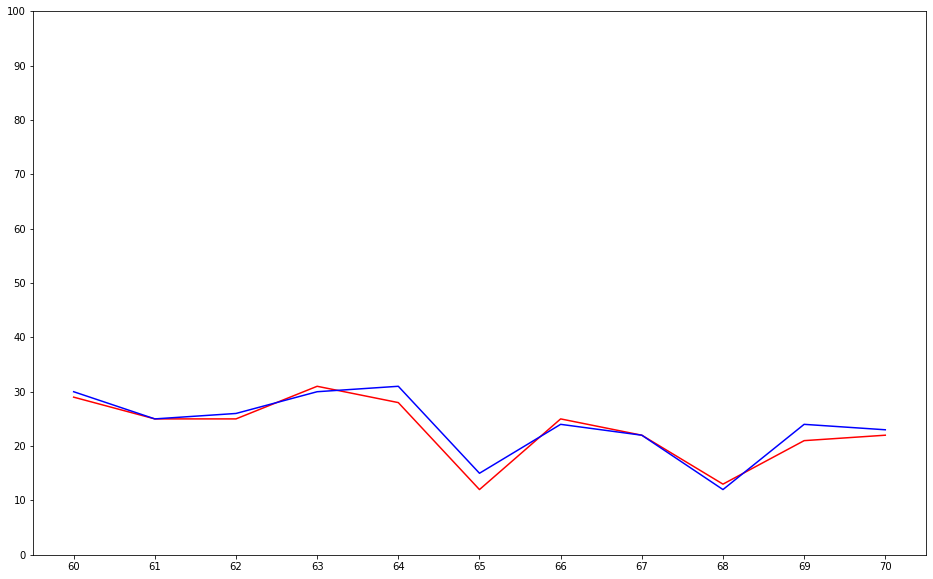

In [46]:
plt.figure(figsize = (16, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 100+1, 10))
plt.xticks(np.arange(60, 70+1, 1.0))
plt.plot(sizes, det_num_sizes_60_70_tested_by_nonsmall_20, "r")
plt.plot(sizes, det_num_sizes_60_70_enhanced_ver2, "b")
# plt.plot(sizes, det_num_sizes_60_70_e, "g")
plt.show()

In [25]:
# Synthesis
det_num_sizes_60_70_tested_by_60_80 = det_num_sizes_60_70

In [45]:
# Synthesis
det_num_sizes_60_70_tested_by_nonsmall_20 = det_num_sizes_60_70

In [14]:
# Synthesis
det_num_sizes_60_70_ = det_num_sizes_60_70

In [42]:
# Synthesis
det_num_sizes_60_70_enhanced_ver2 = det_num_sizes_60_70

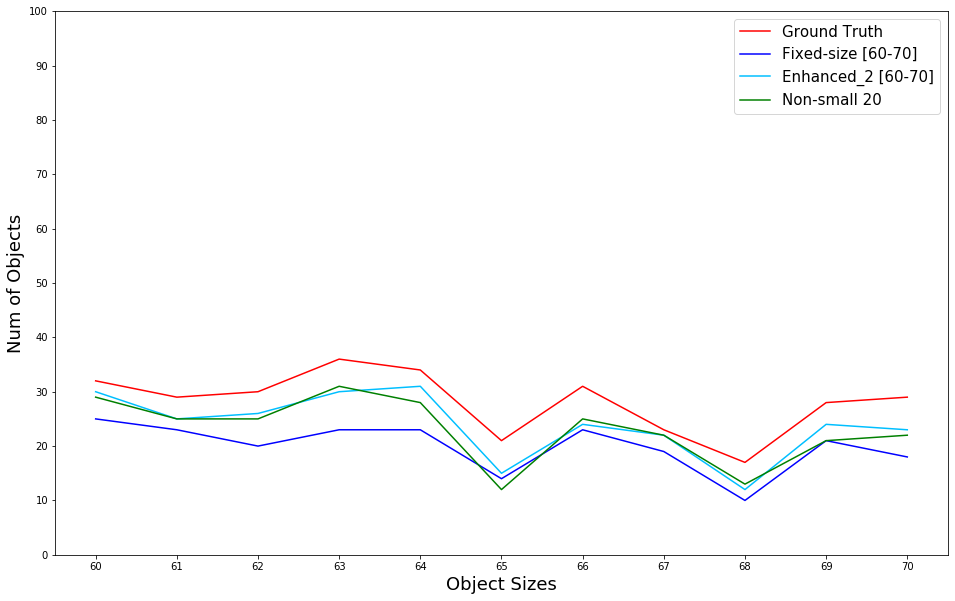

In [50]:
# DISPLAY
plt.figure(figsize = (16, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 100+1, 10))
plt.xticks(np.arange(offset, offset+size_range, 1))

plt.xlabel('Object Sizes', fontsize=18)
plt.ylabel('Num of Objects', fontsize=18)

plt.plot(sizes, gt_num_sizes, "r" , label = "Ground Truth")
plt.plot(sizes, det_num_sizes_60_70_, "b", label = "Fixed-size [60-70]")
# plt.plot(sizes, det_num_sizes_60_70_enhanced_ver2, "darkorange", label = "Enhanced [60-70]")
plt.plot(sizes, det_num_sizes_60_70_enhanced_ver2, "deepskyblue", label = "Enhanced_2 [60-70]")
plt.plot(sizes, det_num_sizes_60_70_tested_by_nonsmall_20, "g", label = "Non-small 20")

plt.legend(fontsize = 15)

plt.show()

## 2. Size 60 - 80

In [35]:
gt_path = glob.glob("./graphs/bdd100k_60_80_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

460


In [36]:
all_detected_gt_boxes = []

for path in gt_path:
    img_name = get_file_name(path)
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_80_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/60_80_person_yolo_custom_epoch_100/{img_name}.txt")

    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

    detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
    
    for box in detected_gt_boxes:
        box = np.array(box)
        all_detected_gt_boxes.append(box)

print(len(all_detected_gt_boxes))

354


In [37]:
size_range = 21 #60-80

sizes = np.zeros(size_range)
gt_num_sizes = np.zeros(size_range)
det_num_sizes_60_80 = np.zeros(size_range)

offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in all_gt_boxes:
    index = box[2] - box[0] - offset
    gt_num_sizes[index] += 1
print(gt_num_sizes)

for box in all_detected_gt_boxes:
    index = box[2] - box[0] - offset
    det_num_sizes_60_80[index] += 1
print(det_num_sizes_60_80)

[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77.
 78. 79. 80.]
[32. 29. 30. 36. 34. 21. 31. 23. 17. 28. 29. 16. 16. 14. 18.  9. 18. 17.
 15. 14. 13.]
[26. 22. 19. 27. 24. 15. 23. 20. 12. 22. 20. 11. 15. 11. 16.  9. 10. 17.
 13. 11. 11.]


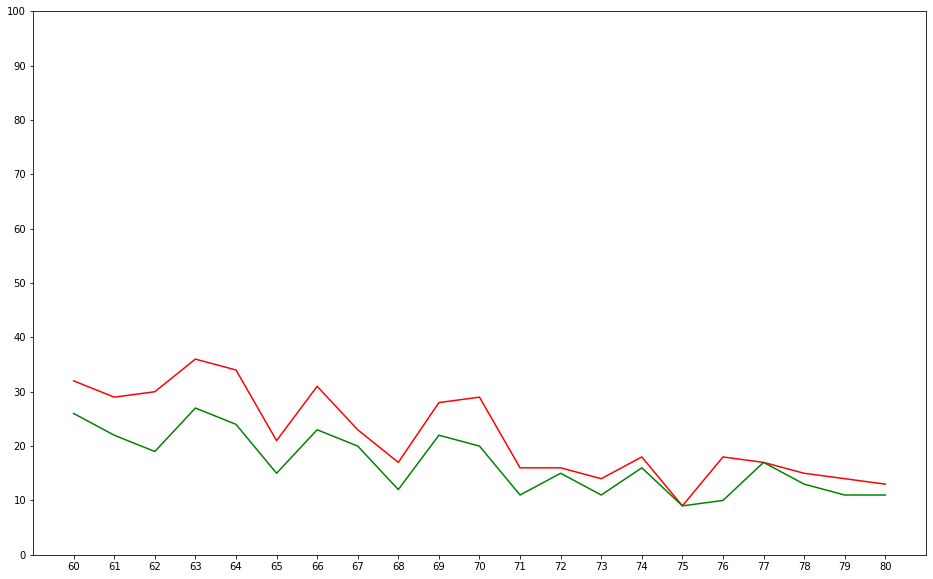

In [223]:
plt.figure(figsize = (16, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 100+1, 10))
plt.xticks(np.arange(60, 80+1, 1.0))
plt.plot(sizes, gt_num_sizes, "r")
plt.plot(sizes, det_num_sizes_60_80, "g")
plt.show()

## Compare 60-70 vs 60-80

In [241]:
size_range = 11 #60-70
sizes = np.zeros(size_range)
offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

gt_num_sizes = np.array([32, 29, 30, 36, 34, 21, 31, 23, 17, 28, 29], dtype = np.float32)
det_num_sizes_60_70 = np.array([25, 23, 20, 23, 23, 14, 23, 19, 10, 21, 18], dtype = np.float32)
det_num_sizes_60_80 = np.array([26, 22, 19, 27, 24, 15, 23, 20, 12, 22, 20], dtype = np.float32)

[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]


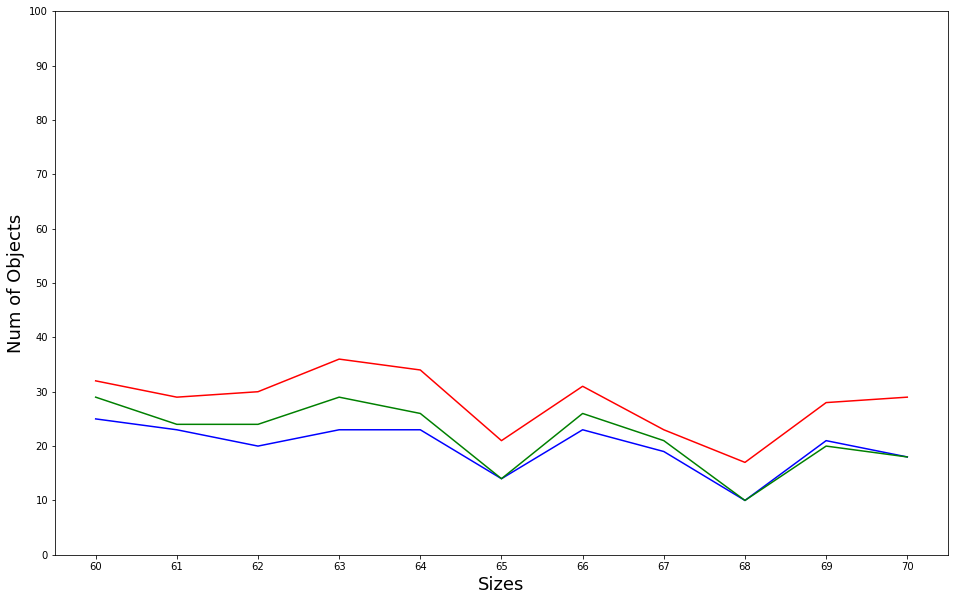

In [58]:
plt.figure(figsize = (16, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 100+1, 10))
plt.xticks(np.arange(60, 70+1, 1.0))

plt.xlabel('Sizes', fontsize=18)
plt.ylabel('Num of Objects', fontsize=18)

plt.plot(sizes, gt_num_sizes, "r")
plt.plot(sizes, det_num_sizes_60_70_, "b")
plt.plot(sizes, det_num_sizes_60_70_enhanced, "g")
plt.show()

## 3. Size Min 20

In [6]:
gt_path = glob.glob("./graphs/bdd100k_non_small_20_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

7381


In [21]:
all_detected_gt_boxes = []

for path in gt_path:
    img_name = get_file_name(path)
    
    folder_name = "60_70_person_tested_on_non_small_20"
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_non_small_20_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{folder_name}/{img_name}.txt")

    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

    detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
    
    for box in detected_gt_boxes:
        box = np.array(box)
        all_detected_gt_boxes.append(box)

print(len(all_detected_gt_boxes))

1128


In [22]:
min_size = 20
max_size = 100

size_range = max_size - min_size + 1

sizes = np.zeros(size_range)
gt_num_sizes = np.zeros(size_range)
det_num_sizes_60_70_data_min_20 = np.zeros(size_range)

offset = min_size

for i in range(len(sizes)):
    sizes[i] = i + offset
# print(sizes)

for box in all_gt_boxes:
    if box[2] - box[0] >= offset and box[2] - box[0] <= offset+size_range-1:
        index = box[2] - box[0] - offset
        gt_num_sizes[index] += 1
# print(gt_num_sizes)

for box in all_detected_gt_boxes:
    if box[2] - box[0] >= offset and box[2] - box[0] <= offset+size_range-1:
        index = box[2] - box[0] - offset
        det_num_sizes_60_70_data_min_20[index] += 1
# print(det_num_sizes_60_70_data_min_20)

In [23]:
# det_num_sizes_60_70_data_min_20_sub_sampling = det_num_sizes_60_70_data_min_20

In [24]:
# det_num_sizes_60_80 = np.array([26, 22, 19, 27, 24, 15, 23, 20, 12, 22, 20], dtype = np.float32)

In [25]:
# det_non_small_20 = det_num_sizes_60_70_data_min_20
# det_60_70_enhanced = det_num_sizes_60_70_data_min_20
# det_60_70_fixed = det_num_sizes_60_70_data_min_20

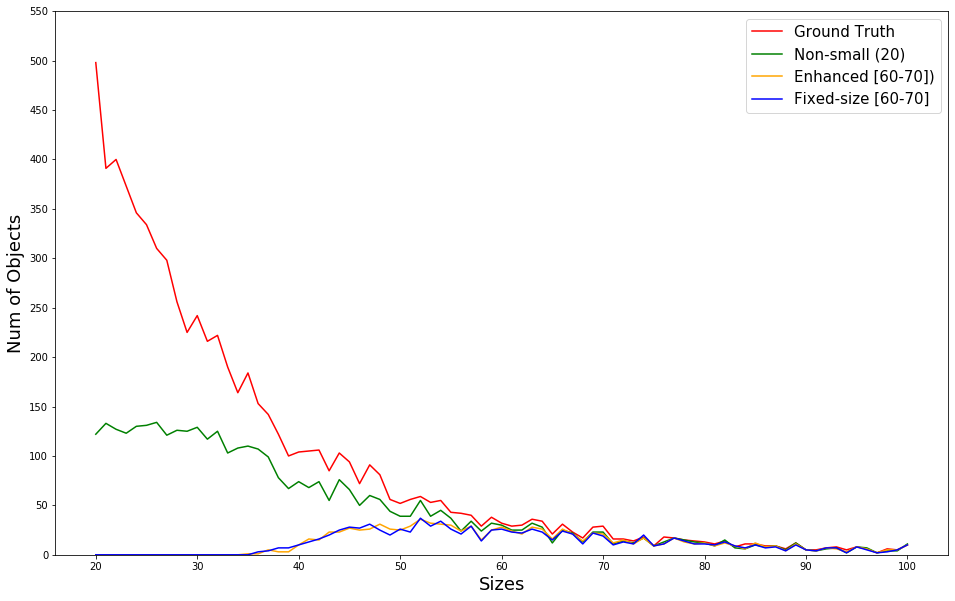

In [27]:
plt.figure(figsize = (16, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 550+1, 50))
plt.xticks(np.arange(offset, offset+size_range, 10))

plt.xlabel('Sizes', fontsize=18)
plt.ylabel('Num of Objects', fontsize=18)

plt.plot(sizes, gt_num_sizes, "r" , label = "Ground Truth")
plt.plot(sizes, det_non_small_20, "g", label = "Non-small (20)")
plt.plot(sizes, det_60_70_enhanced, "orange", label = "Enhanced [60-70])")
plt.plot(sizes, det_60_70_fixed, "b", label = "Fixed-size [60-70]")
plt.legend(fontsize = 15)

plt.show()

# False Positive Display

In [64]:
def false_positive_finding(gt_boxes, pred_boxes, iou_thr):
    
    tp_boxes = process_single_image_results(gt_boxes, pred_boxes, iou_thr)

    fp_boxes = []
    
    for box in pred_boxes:
        if box not in tp_boxes: fp_boxes.append(box)
    
    return fp_boxes

In [99]:
paths = glob.glob("./graphs/60_70_person_tested_on_non_small_20/*.txt")

boxes = []

for path in paths:
    det_boxes_list = file_lines_to_list(path)
    for box in det_boxes_list:
        boxes.append(box)

print(len(boxes))

7414


In [100]:
gt_path = glob.glob("./graphs/bdd100k_non_small_20_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

7381


In [101]:
all_detected_gt_boxes = []

for path in gt_path:
    img_name = get_file_name(path)
    
    folder_name = "60_70_person_tested_on_non_small_20"
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_non_small_20_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{folder_name}/{img_name}.txt")

    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

    detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
    
    for box in detected_gt_boxes:
        box = np.array(box)
        all_detected_gt_boxes.append(box)

print(len(all_detected_gt_boxes))

1128


In [29]:
gt_path = glob.glob("./graphs/bdd100k_non_small_20_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

7381


In [94]:
all_fp_boxes = []

i=0

for path in gt_path:
    img_name = get_file_name(path)
    
    result_file_name = "60_70_person_tested_on_non_small_20"
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_non_small_20_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
    
    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])
    
    detected_fp_boxes = false_positive_finding(gt_boxes, det_boxes, 0.5)
    
#     print(detected_fp_boxes[0])
    
    for box in detected_fp_boxes:
        box = np.array(box)
        all_fp_boxes.append(box)

#     i+=1
#     if i == 6: break
# print(len(detected_fp_boxes))

4


In [95]:
print(len(all_fp_boxes))

7414


In [90]:
print(gt_boxes_list)
print(det_boxes_list)

[['person', '62', '271', '108', '383'], ['person', '257', '286', '285', '345'], ['person', '822', '284', '869', '411'], ['person', '884', '293', '922', '413'], ['person', '951', '283', '988', '395'], ['person', '982', '286', '1011', '389'], ['person', '1040', '284', '1097', '402'], ['person', '713', '291', '769', '403']]
[['person', '0.387314', '1031', '285', '1103', '417'], ['person', '0.331971', '41', '269', '117', '389'], ['person', '0.293246', '801', '264', '876', '413']]


In [91]:
print(gt_boxes)
print(det_boxes)

[[62, 271, 108, 383], [257, 286, 285, 345], [822, 284, 869, 411], [884, 293, 922, 413], [951, 283, 988, 395], [982, 286, 1011, 389], [1040, 284, 1097, 402], [713, 291, 769, 403]]
[[1031, 285, 1103, 417], [41, 269, 117, 389], [801, 264, 876, 413]]


In [92]:
print(detected_fp_boxes)

[[1031, 285, 1103, 417], [41, 269, 117, 389], [801, 264, 876, 413]]


In [93]:
tp_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
print(tp_boxes)

[[62, 271, 108, 383], [822, 284, 869, 411], [1040, 284, 1097, 402]]


In [96]:
min_size = 20
max_size = 100

size_range = max_size - min_size + 1

sizes = np.zeros(size_range)
fp_num_sizes = np.zeros(size_range)

offset = min_size

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in all_fp_boxes:
    if box[2] - box[0] >= min_size and box[2] - box[0] <= max_size:
        index = box[2] - box[0] - offset
        fp_num_sizes[index] += 1
print(fp_num_sizes)

[ 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   3.   5.   0.   3.   4.   6.   7.   4.
   6.  19.  17.  39.  49.  86. 143. 183. 256. 326. 360. 423. 442. 484.
 477. 430. 441. 373. 336. 341. 297. 267. 248. 204. 184. 119. 107.  99.
  79.  74.  68.  59.  45.  40.  26.  18.  24.  22.  19.]


In [91]:
# nonsmall_20_fp = fp_num_sizes

In [97]:
fixed_60_70_enhanced_fp = fp_num_sizes

In [102]:
# fixed_60_70_fp = fp_num_sizes

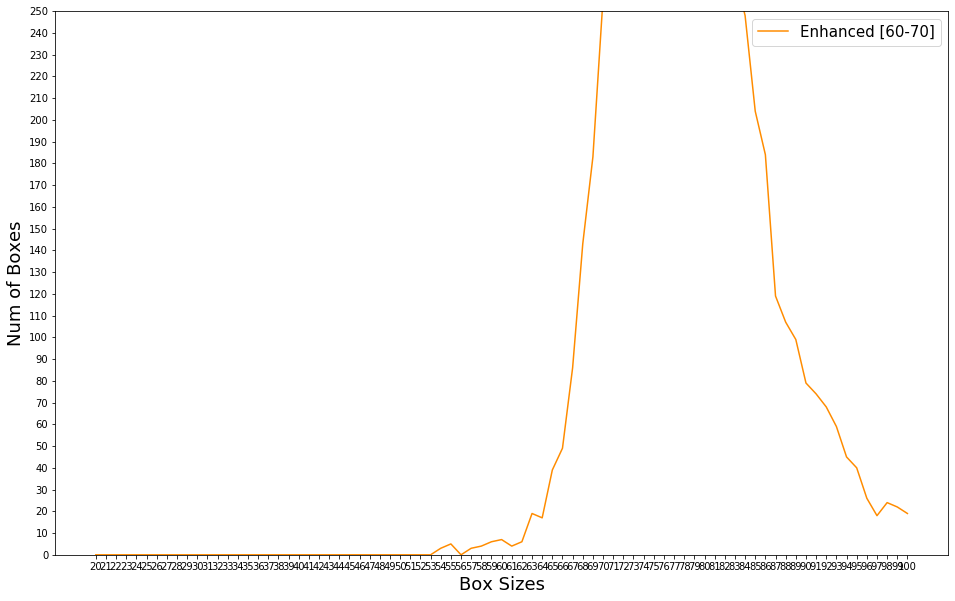

In [98]:
# DISPLAY
plt.figure(figsize = (16, 10))
plt.ylim(0, 250)
plt.yticks(np.arange(0, 250+1, 10))
plt.xticks(np.arange(min_size, max_size+1, 1))

plt.xlabel('Box Sizes', fontsize=18)
plt.ylabel('Num of Boxes', fontsize=18)

# plt.plot(sizes, gt_num_sizes, "r" , label = "Ground Truth")
# plt.plot(sizes, fixed_60_70_fp, "b", label = "Fixed-size [60-70]")
plt.plot(sizes, fixed_60_70_enhanced_fp, "darkorange", label = "Enhanced [60-70]")
# plt.plot(sizes, nonsmall_20_fp, "g", label = "Non-small 20")

plt.legend(fontsize = 15)

plt.show()